In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [6]:
audio_probs=torch.load('../datasets/fusion/audio_val_probs.pt')
text_probs=torch.load('../datasets/fusion/text_val_probs.pt')[:173]
labels=torch.load('../datasets/fusion/fusion_val_labels.pt')

In [21]:
print(labels)

tensor([4, 4, 4, 2, 3, 3, 1, 1, 1, 4, 3, 3, 0, 0, 3, 3, 2, 3, 3, 4, 1, 4, 4, 3,
        1, 0, 4, 4, 1, 4, 1, 3, 0, 1, 1, 0, 1, 1, 4, 1, 3, 4, 1, 3, 2, 3, 3, 3,
        0, 4, 0, 1, 1, 0, 3, 0, 0, 1, 0, 0, 2, 0, 4, 2, 0, 0, 1, 0, 3, 4, 4, 0,
        1, 1, 0, 3, 3, 2, 3, 4, 4, 2, 2, 3, 0, 4, 4, 2, 0, 3, 4, 0, 2, 4, 1, 1,
        0, 3, 0, 0, 0, 4, 4, 3, 1, 3, 0, 1, 0, 1, 3, 0, 1, 4, 2, 3, 1, 3, 0, 3,
        3, 4, 4, 1, 2, 1, 3, 4, 2, 0, 0, 2, 1, 1, 1, 1, 3, 2, 3, 3, 0, 3, 1, 4,
        4, 0, 1, 0, 4, 2, 0, 4, 4, 0, 0, 1, 4, 3, 0, 4, 3, 2, 1, 3, 0, 1, 4, 1,
        3, 2, 4, 2, 4])


In [22]:
print(audio_probs.shape[0])
print(text_probs.shape[0])
print(labels.shape[0])

173
173
173


In [23]:
assert audio_probs.shape[0] == text_probs.shape[0] == labels.shape[0], "Mismatched dataset sizes"

In [24]:
X_fusion=torch.cat((audio_probs, text_probs), dim=1)
y_fusion=labels

dataset=TensorDataset(X_fusion, y_fusion)
dataloader=DataLoader(dataset, batch_size=32, shuffle=False)

In [25]:
print(dataset)
print(y_fusion)

tensor([4, 4, 4, 2, 3, 3, 1, 1, 1, 4, 3, 3, 0, 0, 3, 3, 2, 3, 3, 4, 1, 4, 4, 3,
        1, 0, 4, 4, 1, 4, 1, 3, 0, 1, 1, 0, 1, 1, 4, 1, 3, 4, 1, 3, 2, 3, 3, 3,
        0, 4, 0, 1, 1, 0, 3, 0, 0, 1, 0, 0, 2, 0, 4, 2, 0, 0, 1, 0, 3, 4, 4, 0,
        1, 1, 0, 3, 3, 2, 3, 4, 4, 2, 2, 3, 0, 4, 4, 2, 0, 3, 4, 0, 2, 4, 1, 1,
        0, 3, 0, 0, 0, 4, 4, 3, 1, 3, 0, 1, 0, 1, 3, 0, 1, 4, 2, 3, 1, 3, 0, 3,
        3, 4, 4, 1, 2, 1, 3, 4, 2, 0, 0, 2, 1, 1, 1, 1, 3, 2, 3, 3, 0, 3, 1, 4,
        4, 0, 1, 0, 4, 2, 0, 4, 4, 0, 0, 1, 4, 3, 0, 4, 3, 2, 1, 3, 0, 1, 4, 1,
        3, 2, 4, 2, 4])


In [26]:
class FusionMLP(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=32, num_classes=5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout= nn.Dropout(0.2)
        self.fc2=nn.Linear(hidden_dim, num_classes)
        self.output_dim=num_classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
model=FusionMLP()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [28]:
for epoch in range(20):
    model.train()
    total_loss, correct = 0, 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * x_batch.size(0)
        preds=outputs.argmax(dim=1)
        correct += (preds == y_batch).sum().item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataset):.4f}, Accuracy: {correct/len(dataset):.4f}')

Epoch 1, Loss: 1.6098, Accuracy: 0.1965
Epoch 2, Loss: 1.5915, Accuracy: 0.2312
Epoch 3, Loss: 1.5720, Accuracy: 0.2717
Epoch 4, Loss: 1.5678, Accuracy: 0.2428
Epoch 5, Loss: 1.5603, Accuracy: 0.2486
Epoch 6, Loss: 1.5439, Accuracy: 0.3179
Epoch 7, Loss: 1.5412, Accuracy: 0.3121
Epoch 8, Loss: 1.5189, Accuracy: 0.3699
Epoch 9, Loss: 1.5115, Accuracy: 0.3642
Epoch 10, Loss: 1.5007, Accuracy: 0.4335
Epoch 11, Loss: 1.4899, Accuracy: 0.4162
Epoch 12, Loss: 1.4763, Accuracy: 0.4971
Epoch 13, Loss: 1.4485, Accuracy: 0.5549
Epoch 14, Loss: 1.4424, Accuracy: 0.5723
Epoch 15, Loss: 1.4159, Accuracy: 0.6012
Epoch 16, Loss: 1.4146, Accuracy: 0.6012
Epoch 17, Loss: 1.3813, Accuracy: 0.6301
Epoch 18, Loss: 1.3764, Accuracy: 0.6185
Epoch 19, Loss: 1.3572, Accuracy: 0.6127
Epoch 20, Loss: 1.3334, Accuracy: 0.6301


In [29]:
torch.save(model.state_dict(), 'models/fusion_mlp_final.pt')

In [30]:
fusion_inputs=torch.cat([audio_probs, text_probs], dim=1)
labels=labels[:fusion_inputs.size(0)]

fusion_dataset=TensorDataset(fusion_inputs, labels)
fusion_loader=DataLoader(fusion_dataset, batch_size=32, shuffle=False)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=FusionMLP(input_dim=fusion_inputs.shape[1], hidden_dim=32).to(device)
model.load_state_dict(torch.load('models/fusion_mlp_final.pt', map_location=device))
model.eval()


fusion_preds=[]
with torch.no_grad():
    for x,_ in fusion_loader:
        x=x.to(device)
        outputs=model(x)
        preds=torch.argmax(outputs, dim=1)
        fusion_preds.extend(preds.cpu().numpy())


In [31]:
print(fusion_preds)

[4, 1, 4, 2, 3, 3, 1, 1, 1, 3, 3, 3, 0, 0, 3, 1, 1, 3, 3, 4, 1, 4, 1, 3, 1, 0, 4, 3, 1, 1, 0, 3, 3, 1, 3, 1, 1, 1, 4, 3, 3, 3, 1, 3, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 0, 0, 0, 0, 0, 3, 0, 4, 1, 1, 4, 1, 0, 3, 4, 1, 4, 4, 3, 1, 3, 3, 1, 3, 3, 1, 1, 4, 3, 0, 3, 4, 4, 0, 3, 0, 0, 3, 0, 1, 1, 0, 3, 4, 0, 0, 0, 1, 3, 1, 3, 0, 1, 0, 1, 3, 0, 1, 4, 3, 3, 1, 3, 0, 1, 3, 4, 4, 3, 4, 3, 3, 4, 3, 0, 0, 1, 1, 1, 4, 1, 3, 1, 3, 1, 0, 3, 4, 0, 3, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 3, 3, 0, 4, 3, 2, 1, 3, 1, 1, 1, 1, 3, 4, 4, 4, 4]


In [32]:
print(labels)

tensor([4, 4, 4, 2, 3, 3, 1, 1, 1, 4, 3, 3, 0, 0, 3, 3, 2, 3, 3, 4, 1, 4, 4, 3,
        1, 0, 4, 4, 1, 4, 1, 3, 0, 1, 1, 0, 1, 1, 4, 1, 3, 4, 1, 3, 2, 3, 3, 3,
        0, 4, 0, 1, 1, 0, 3, 0, 0, 1, 0, 0, 2, 0, 4, 2, 0, 0, 1, 0, 3, 4, 4, 0,
        1, 1, 0, 3, 3, 2, 3, 4, 4, 2, 2, 3, 0, 4, 4, 2, 0, 3, 4, 0, 2, 4, 1, 1,
        0, 3, 0, 0, 0, 4, 4, 3, 1, 3, 0, 1, 0, 1, 3, 0, 1, 4, 2, 3, 1, 3, 0, 3,
        3, 4, 4, 1, 2, 1, 3, 4, 2, 0, 0, 2, 1, 1, 1, 1, 3, 2, 3, 3, 0, 3, 1, 4,
        4, 0, 1, 0, 4, 2, 0, 4, 4, 0, 0, 1, 4, 3, 0, 4, 3, 2, 1, 3, 0, 1, 4, 1,
        3, 2, 4, 2, 4])


In [33]:
cm=confusion_matrix(labels, fusion_preds)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Angry", "Sad", "Neutral", "Surprised", "Happy"])

<Figure size 800x600 with 0 Axes>

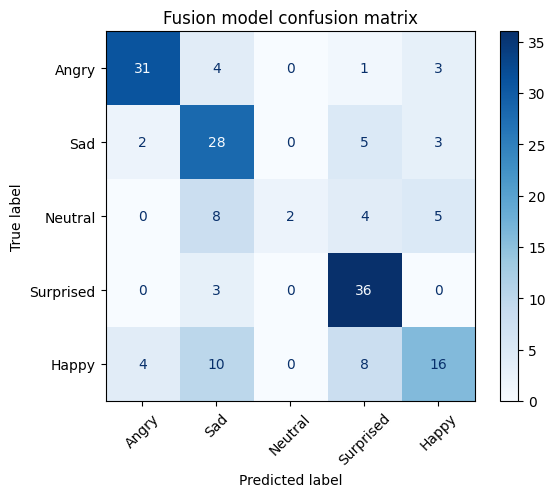

In [34]:
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Fusion model confusion matrix")
plt.show()

In [35]:
from collections import Counter
print(Counter(fusion_preds))

print(torch.bincount(labels))

idx = 10
print("Label:", labels[idx].item(), "Pred:", fusion_preds[idx])
print("Audio probs:", audio_probs[idx])
print("Text probs:", text_probs[idx])

Counter({3: 54, 1: 53, 0: 37, 4: 27, 2: 2})
tensor([39, 38, 19, 39, 38])
Label: 3 Pred: 3
Audio probs: tensor([4.8069e-03, 1.1748e-04, 7.8629e-04, 9.7921e-01, 1.5080e-02])
Text probs: tensor([3.4193e-06, 5.1706e-06, 2.2104e-07, 9.9999e-01, 4.8055e-06])


In [36]:
print(f"Audio probs sum: {audio_probs.sum(dim=1)[:5]}")  # Should be 1.0 if softmax
print(f"Text probs sum: {text_probs.sum(dim=1)[:5]}")    # Same

print(f"Fusion inputs sample: {fusion_inputs[10]}")  # Check concatenation looks ok


Audio probs sum: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Text probs sum: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
Fusion inputs sample: tensor([4.8069e-03, 1.1748e-04, 7.8629e-04, 9.7921e-01, 1.5080e-02, 3.4193e-06,
        5.1706e-06, 2.2104e-07, 9.9999e-01, 4.8055e-06])


In [37]:
correct_matches = sum((labels.numpy() == np.array(fusion_preds)))
print(f"Exact matches: {correct_matches} / {len(labels)}")


Exact matches: 113 / 173
